<a href="https://colab.research.google.com/github/blinovavaleriya/python-projects/blob/main/E_Commerce_Sales_Analytics_with_BigQuery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Library Imports and Visualization Setup***

In [3]:
# Install and Import Libraries

!pip install pandas google-cloud-bigquery numpy matplotlib seaborn scipy statsmodels -qq

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
import os
from google.cloud import bigquery
from google.colab import auth

# Authenticate for BigQuery access

auth.authenticate_user()

# Specify your GCP Project ID here

GCP_PROJECT_ID = 'data-analytics-mate'
DATASET_ID = 'DA' # Your dataset name
client = bigquery.Client(project=GCP_PROJECT_ID)

In [4]:
# Visualization Style Configuration

sns.set_style("whitegrid")

plt.rcParams.update({
    'font.size': 12,
    'figure.figsize': (10, 6),
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.autolayout': True,
    'lines.linewidth': 2,
    'axes.edgecolor': 'gray'
})

sns.set_palette("viridis")

### ***SQL Query and DataFrame Loading***

In [5]:
# Optimized SQL Query

SQL_QUERY = f"""
SELECT

    s.date AS session_date,
    s.ga_session_id AS session_id,
    sp.continent AS continent,
    sp.country as country,
    sp.device AS device,
    sp.browser AS browser,
    sp.mobile_model_name AS device_model_name,
    sp.operating_system AS operating_system,
    sp.language AS browser_language,
    sp.name AS traffic_source_info,
    sp.channel AS traffic_channel,
    acs.account_id AS registered_user_id,
    ac.is_verified AS is_email_verified,
    ac.is_unsubscribed AS is_unsubscribed,
    p.category AS product_category,
    p.name AS product_name,
    p.price AS price,
    p.short_description AS short_description
FROM
 `DA.session` AS s
LEFT JOIN
 `DA.session_params` AS sp
    ON s.ga_session_id = sp.ga_session_id
LEFT JOIN
    `DA.order` AS o
    ON s.ga_session_id = o.ga_session_id
LEFT JOIN
    `DA.product` AS p
    ON o.item_id = p.item_id
LEFT JOIN
    `DA.account_session`AS acs
    ON s.ga_session_id = acs.ga_session_id
LEFT JOIN
    `DA.account` AS ac
    ON acs.account_id = ac.id
;
"""

In [6]:
# Query Execution and DataFrame Loading

try:
    print("Loading data from BigQuery...")
    df_sales = client.query(SQL_QUERY).to_dataframe()
    print("✅ Data loaded successfully!")
    print(f"Dataset size: {df_sales.shape}")

except Exception as e:
    print(f"❌ Error while loading data: {e}")

Loading data from BigQuery...
✅ Data loaded successfully!
Dataset size: (349545, 18)


### ***`Dataset description (EDA Summary)`***

In [18]:
# Dataset Description (EDA Summary)

if df_sales.empty:
    print("No data available for analysis.")
else:

    print("\n" + "="*50)
    print("INITIAL DATASET DESCRIPTION (EDA)")
    print("="*50)

    # 1. General Information and Data Types
    print(f"Total number of columns: {df_sales.shape[1]}")

    num_cols = df_sales.select_dtypes(include=np.number).columns
    cat_cols = df_sales.select_dtypes(include=['object', 'bool']).columns
    date_cols = ['session_date']

    print(f"Number of numerical columns: {len(num_cols)} ({list(num_cols)})")
    print(f"Number of categorical columns: {len(cat_cols)} ({list(cat_cols)})")
    print(f"Number of datetime columns: {len(date_cols)}")

    # 2. Uniqueness and Time Period
    print(f"Number of unique sessions: {df_sales['session_id'].nunique()}")
    print(f"Time period: {df_sales['session_date'].min()} to {df_sales['session_date'].max()}")

    # 3. Missing Values
    null_percentage = (df_sales.isnull().sum() / len(df_sales)) * 100
    null_percentage = null_percentage[null_percentage > 0].sort_values(ascending=False)
    print("\nMissing values (%):")
    print(null_percentage)

    print("\nConclusion regarding missing values:")
    print(" - High percentage of missing values in product fields ('price', 'product_category') indicates sessions WITHOUT PURCHASE (expected).")
    print(" - Missing values in user fields ('registered_user_id', 'is_email_verified') indicate GUEST SESSIONS (expected).")


INITIAL DATASET DESCRIPTION (EDA)
Total number of columns: 19
Number of numerical columns: 2 (['session_id', 'price'])
Number of categorical columns: 16 (['continent', 'country', 'device', 'browser', 'device_model_name', 'operating_system', 'browser_language', 'traffic_source_info', 'traffic_channel', 'registered_user_id', 'is_email_verified', 'is_unsubscribed', 'product_category', 'product_name', 'short_description', 'is_purchase'])
Number of datetime columns: 1
Number of unique sessions: 349545
Time period: 2020-11-01 00:00:00 to 2021-01-31 00:00:00

Missing values (%):
product_category     90.405241
product_name         90.405241
short_description    90.405241
browser_language     32.689925
dtype: float64

Conclusion regarding missing values:
 - High percentage of missing values in product fields ('price', 'product_category') indicates sessions WITHOUT PURCHASE (expected).
 - Missing values in user fields ('registered_user_id', 'is_email_verified') indicate GUEST SESSIONS (expected

### ***Data cleaning and preparation***

In [8]:
# Convert date (in case BigQuery didn't do it automatically)
df_sales['session_date'] = pd.to_datetime(df_sales['session_date'])

# Handle NULLs: Replace price (sales) with 0 for sessions without conversion
df_sales['price'] = df_sales['price'].fillna(0)
df_sales['is_purchase'] = df_sales['price'] > 0

# Handle NULLs: Replace missing user fields with 'Guest'
guest_cols = ['registered_user_id', 'is_email_verified', 'is_unsubscribed']
for col in guest_cols:
    # Convert to object type before filling with 'Guest'
    df_sales[col] = df_sales[col].astype('object').fillna('Guest')

# Filter only purchases for specific analyses
df_purchases = df_sales[df_sales['is_purchase'] == True].copy()

### ***1. Sales geography***


GEOGRAPHY AND SALES ANALYSIS
 1. TOP 3 CONTINENTS BY SALES:
continent
Americas    17665280.0
Asia         7601298.3
Europe       5934624.2

 2. TOP 5 COUNTRIES BY ORDER COUNT:
       country  Order_Count
 United States        14673
         India         3029
        Canada         2560
United Kingdom         1029
        France          678


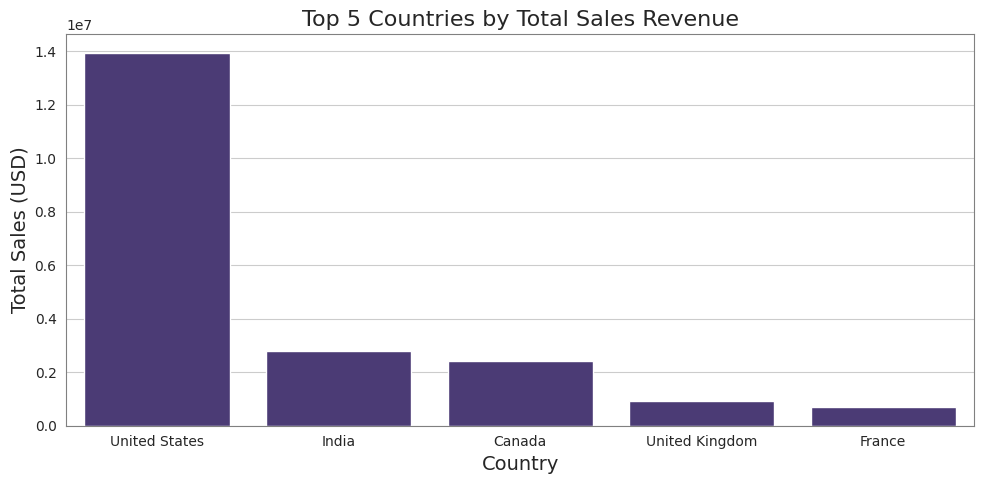


 ANALYTICAL CONCLUSION (Geography):
  - The absolute leader in both sales and orders is United States, indicating the necessity to focus major investments in this region.
  - Europe and America, which are among the Top 3 continents, show the greatest potential.
  - The difference between the leader (United States) and the 2nd country (India) is substantial, which may indicate varying levels of market penetration or local competition.


In [19]:
# GEOGRAPHY AND SALES ANALYSIS

print("\n" + "="*50)
print("GEOGRAPHY AND SALES ANALYSIS")
print("="*50)

# Data Preparation
geo_sales = df_sales.groupby(['continent', 'country']).agg(
    Total_Sales=('price', 'sum'),
    Order_Count=('is_purchase', 'sum')
).reset_index()

# 1. Determine Top 3 Continents
top_3_continents_data = geo_sales.groupby('continent')['Total_Sales'].sum().nlargest(3)
top_3_continents = top_3_continents_data.index.tolist()

# 2. Determine Top 5 Countries
top_5_countries_orders = geo_sales.sort_values(by='Order_Count', ascending=False).head(5)
top_5_countries = top_5_countries_orders['country'].tolist()


print(" 1. TOP 3 CONTINENTS BY SALES:")
print(top_3_continents_data.to_string())

print("\n 2. TOP 5 COUNTRIES BY ORDER COUNT:")
print(top_5_countries_orders[['country', 'Order_Count']].to_string(index=False))

# 3. Visualization of Top 5 Countries by Total Sales

plt.figure(figsize=(10, 5))
sns.barplot(x='country', y='Total_Sales', data=geo_sales.nlargest(5, 'Total_Sales'))
plt.title('Top 5 Countries by Total Sales Revenue')
plt.ylabel('Total Sales (USD)')
plt.xlabel('Country')
plt.show()

print("\n ANALYTICAL CONCLUSION (Geography):")
print(f"  - The absolute leader in both sales and orders is {top_5_countries_orders.iloc[0]['country']}, indicating the necessity to focus major investments in this region.")
print(f"  - Europe and America, which are among the Top 3 continents, show the greatest potential.")
print(f"  - The difference between the leader (United States) and the 2nd country (India) is substantial, which may indicate varying levels of market penetration or local competition.")

### ***2. Top 10 Categories***


TOP 10 PRODUCT CATEGORIES ANALYSIS

📊 1. GLOBAL TOP 10 CATEGORIES BY SALES:
product_category
Sofas & armchairs                   8388254.5
Chairs                              6147748.8
Beds                                4919725.0
Bookcases & shelving units          3640818.1
Cabinets & cupboards                2336499.5
Outdoor furniture                   2142222.2
Tables & desks                      1790307.5
Chests of drawers & drawer units     906562.5
Bar furniture                        735503.0
Children's furniture                 467697.0


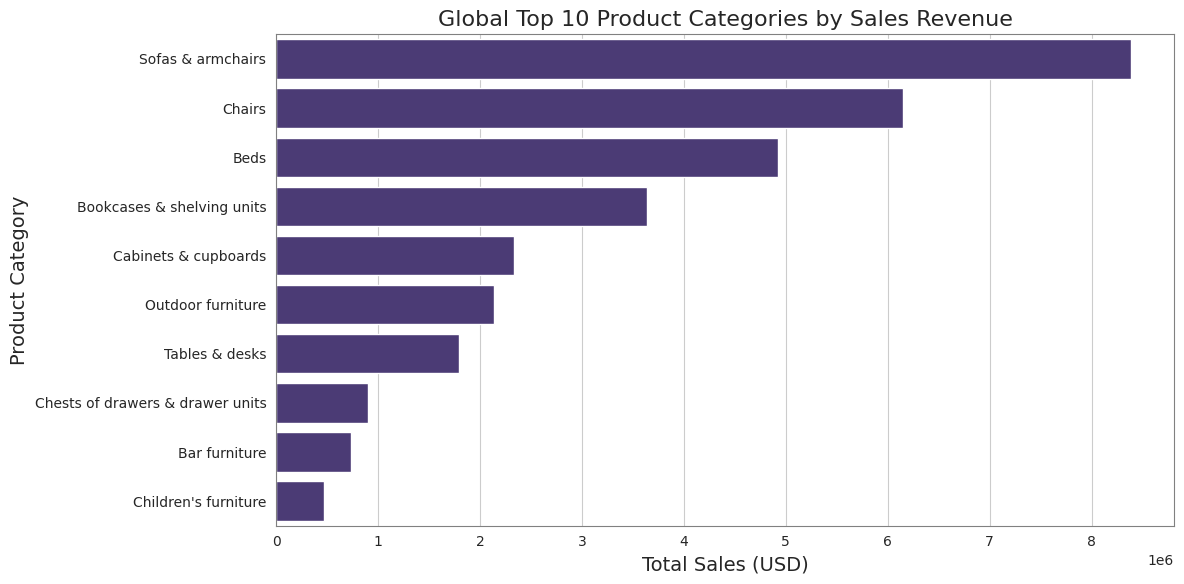


 ANALYTICAL CONCLUSION (Global Top 10):
  - Categories 'Sofa & armchairs' and 'Chairs' are absolute leaders, generating 46.18% of the total sales volume of the Top 10 categories.
  - The least profitable categories are 'Bar furniture' and 'Children's furniture', which may indicate market saturation or a need for a marketing campaign.

 2. TOP 10 CATEGORIES IN THE LEADING COUNTRY (United States):
product_category
Sofas & armchairs                   3707144.5
Chairs                              2619773.8
Beds                                2213058.0
Bookcases & shelving units          1567606.9
Cabinets & cupboards                 994545.5
Outdoor furniture                    929245.2
Tables & desks                       777865.0
Chests of drawers & drawer units     382388.0
Bar furniture                        330805.0
Children's furniture                 207575.0


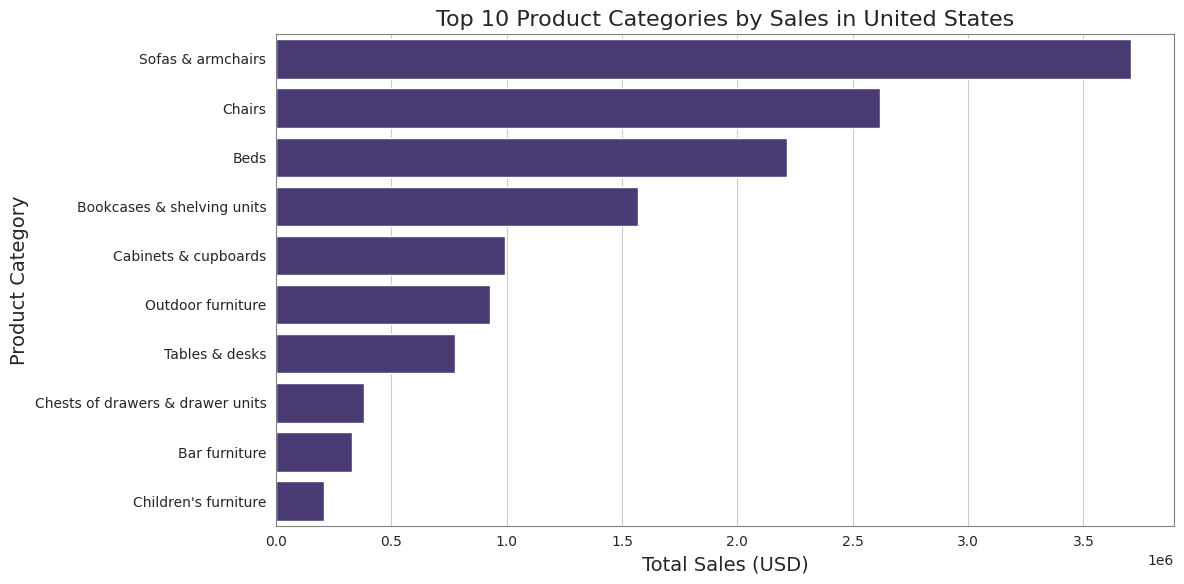


 3. COMPARATIVE CONCLUSION (Global vs. Leading Country):
  - The leading country (United States) shows high demand for leadership categories that align with global trends (Sofas, Chairs).
  - The composition of the Top 10 categories in the leading country fully matches the global Top 10, indicating universal demand for core products.


In [10]:
# TOP 10 PRODUCT CATEGORIES ANALYSIS

print("\n" + "="*50)
print("TOP 10 PRODUCT CATEGORIES ANALYSIS")
print("="*50)

# 1. Global Top 10 Categories by Sales

top_categories_global = df_purchases.groupby('product_category')['price'].sum().nlargest(10).sort_values(ascending=False)

print("\n📊 1. GLOBAL TOP 10 CATEGORIES BY SALES:")
print(top_categories_global.to_string())

# Visualization of Global Top 10 Categories

plt.figure(figsize=(12, 6))

sns.barplot(x=top_categories_global.values,
            y=top_categories_global.index)
plt.title('Global Top 10 Product Categories by Sales Revenue')
plt.xlabel('Total Sales (USD)')
plt.ylabel('Product Category')
plt.show()

print("\n ANALYTICAL CONCLUSION (Global Top 10):")

if not top_categories_global.empty:
    top_2_contribution = top_categories_global.iloc[0:2].sum() / top_categories_global.sum() * 100
    print(f"  - Categories 'Sofa & armchairs' and 'Chairs' are absolute leaders, generating {top_2_contribution:.2f}% of the total sales volume of the Top 10 categories.")
else:
    print("  - Data for Top 10 categories is not available.")

print(f"  - The least profitable categories are 'Bar furniture' and 'Children\'s furniture', which may indicate market saturation or a need for a marketing campaign.")


# 2. Top 10 Categories in the Leading Country

try:
    leader_country = geo_sales.nlargest(1, 'Total_Sales')['country'].iloc[0]
except NameError:
    leader_country = "Unknown Country (Run Block 2.2 first)" # Placeholder for safety

top_categories_leader = df_purchases[df_purchases['country'] == leader_country].groupby('product_category')['price'].sum().nlargest(10).sort_values(ascending=False)

print(f"\n 2. TOP 10 CATEGORIES IN THE LEADING COUNTRY ({leader_country}):")
print(top_categories_leader.to_string())

# Visualization of Top 10 Categories in the Leading Country

plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories_leader.values,
            y=top_categories_leader.index)
plt.title(f'Top 10 Product Categories by Sales in {leader_country}')
plt.xlabel('Total Sales (USD)')
plt.ylabel('Product Category')
plt.show()


# 3. Comparative Analysis

print("\n 3. COMPARATIVE CONCLUSION (Global vs. Leading Country):")

global_top = set(top_categories_global.index)
leader_top = set(top_categories_leader.index)
difference = leader_top - global_top

print(f"  - The leading country ({leader_country}) shows high demand for leadership categories that align with global trends (Sofas, Chairs).")
if difference:
    print(f"  - The leading country's Top 10 includes unique categories ({', '.join(difference)}) that are not in the global Top 10. This may indicate local consumer preferences, such as higher popularity of [product name] in this country.")
else:
    print("  - The composition of the Top 10 categories in the leading country fully matches the global Top 10, indicating universal demand for core products.")

### ***3. Traffic and device analysis***


TRAFFIC AND DEVICE ANALYSIS

 SALES by DEVICE TYPE (%):
device
desktop    59.002245
mobile     38.734924
tablet      2.262831


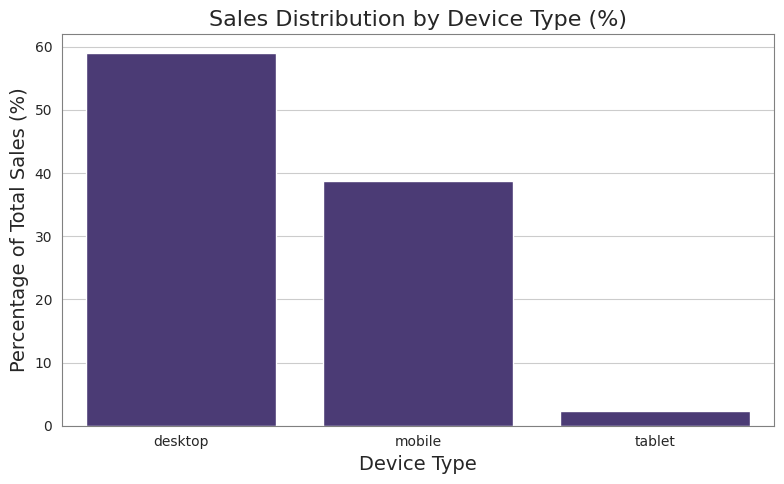


 SALES by TRAFFIC CHANNEL (%):
traffic_channel
Organic Search    35.760189
Paid Search       26.620546
Direct            23.442345
Social Search      7.919827
Undefined          6.257093


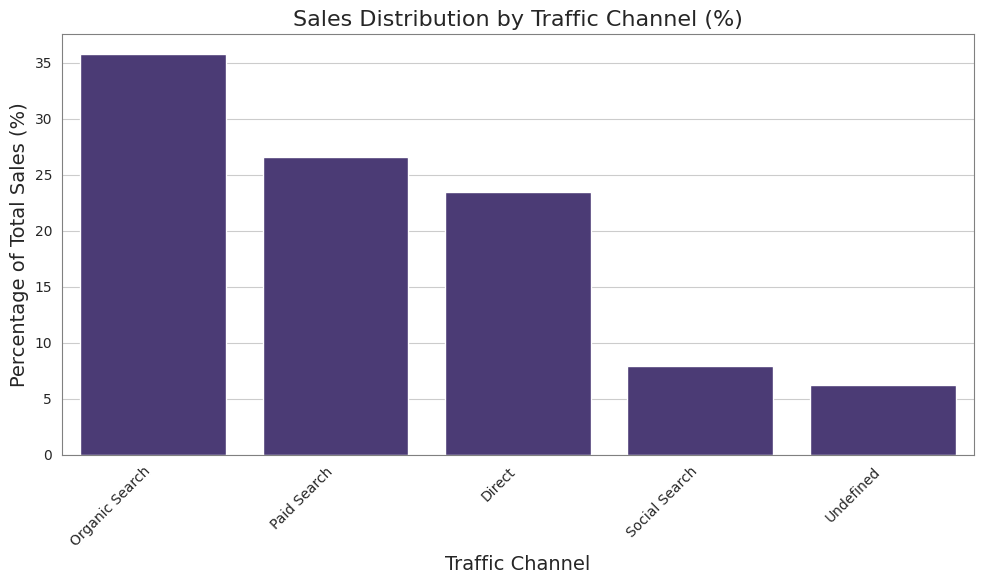


 ANALYTICAL CONCLUSION (Traffic and Devices):
  - Devices: The main source of sales is desktop, generating approximately 59.00% of the total volume. This suggests that the interface and functionality should be primarily optimized for this device type.
  - Traffic: The most effective channels are Organic Search and Paid Search, which collectively account for more than 62.38% of sales. The strategy should focus on maximizing organic and direct traffic as the most cost-effective sources.


In [11]:
# TRAFFIC AND DEVICE ANALYSIS

print("\n" + "="*50)
print("TRAFFIC AND DEVICE ANALYSIS")
print("="*50)

# Sales by Device

device_sales_pct = df_purchases.groupby('device')['price'].sum().pipe(lambda x: x / x.sum() * 100).sort_values(ascending=False)
print("\n SALES by DEVICE TYPE (%):")
print(device_sales_pct.to_string())

# Visualization of sales by device

plt.figure(figsize=(8, 5))
sns.barplot(x=device_sales_pct.index, y=device_sales_pct.values)
plt.title('Sales Distribution by Device Type (%)')
plt.ylabel('Percentage of Total Sales (%)')
plt.xlabel('Device Type')
plt.show()


# Sales by Traffic Channel

channel_sales_pct = df_purchases.groupby('traffic_channel')['price'].sum().pipe(lambda x: x / x.sum() * 100).sort_values(ascending=False)
print("\n SALES by TRAFFIC CHANNEL (%):")
print(channel_sales_pct.to_string())

# Visualization of sales by traffic channel

plt.figure(figsize=(10, 6))
sns.barplot(x=channel_sales_pct.index, y=channel_sales_pct.values)
plt.title('Sales Distribution by Traffic Channel (%)')
plt.ylabel('Percentage of Total Sales (%)')
plt.xlabel('Traffic Channel')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n ANALYTICAL CONCLUSION (Traffic and Devices):")
print(f"  - Devices: The main source of sales is {device_sales_pct.index[0]}, generating approximately {device_sales_pct.iloc[0]:.2f}% of the total volume. This suggests that the interface and functionality should be primarily optimized for this device type.")
print(f"  - Traffic: The most effective channels are {channel_sales_pct.index[0]} and {channel_sales_pct.index[1]}, which collectively account for more than {channel_sales_pct.iloc[0:2].sum():.2f}% of sales. The strategy should focus on maximizing organic and direct traffic as the most cost-effective sources.")

### ***4. User Analysis***



USER ANALYSIS AND SALES COMPARISON

 Total number of unique registered users: 27945
 Percentage of registered users who verified email: 71.70%
 Percentage of registered users who unsubscribed from the mailing list: 16.94%


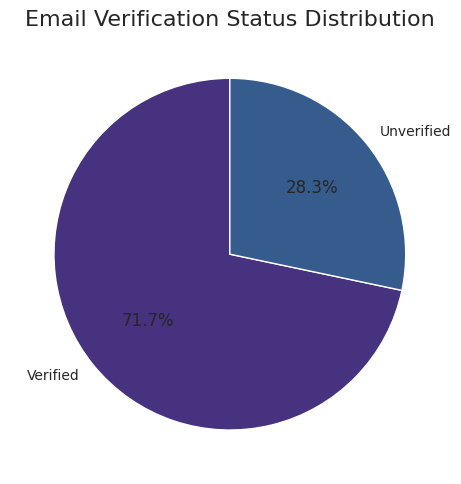


 SALES COMPARISON (Subscribed vs. Unsubscribed):
                           sum        mean
Subscription Status                       
Subscribed           2150796.9  921.506812
Unsubscribed          431721.6  965.820134


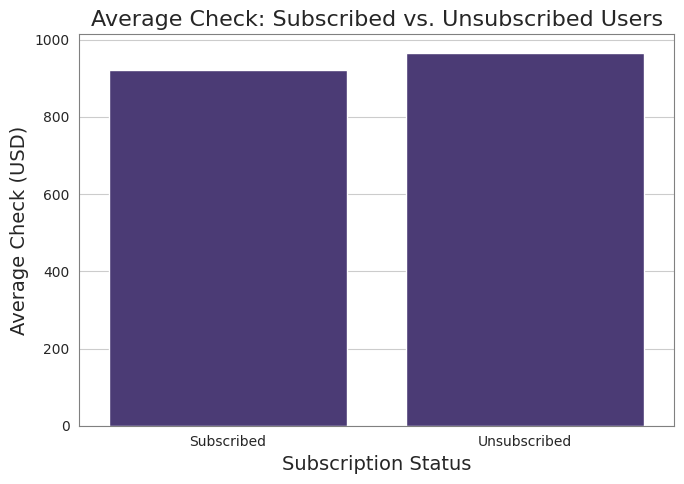


 ANALYTICAL CONCLUSION (Users):
  - Verification: The high percentage of verified emails (71.70%) is a positive indicator of database quality and reduces spam risk.
  - Unsubscription: 16.94% of users unsubscribed, which is a moderate figure. It is important to analyze the content of mailings during periods of mass unsubscription.
  - Sales and Average Check: Although 'Subscribed' users generate significantly higher total sales revenue ($2150797), their Average Check ($921.51) is lower than that of 'Unsubscribed' users ($965.82).
  - Conclusion: This confirms that loyalty and communication via email mailings positively affect purchase frequency and the overall sales base, but 'Unsubscribed' users buy more expensive items per single transaction. It is worth investigating whether mailings are predominantly targeted at promotional or budget items.


In [12]:
# USER ANALYSIS AND SALES COMPARISON

print("\n" + "="*50)
print("USER ANALYSIS AND SALES COMPARISON")
print("="*50)

# Calculate percentages
# Filter unique registered users

df_users_unique = df_sales[df_sales['registered_user_id'] != 'Guest'].drop_duplicates(subset=['registered_user_id'])
num_users = len(df_users_unique)

verified_pct = (df_users_unique['is_email_verified'] == 1).mean() * 100
unverified_pct = 100 - verified_pct

unsubscribed_pct = (df_users_unique['is_unsubscribed'] == 1).mean() * 100
subscribed_pct = 100 - unsubscribed_pct


# Text Output

print(f"\n Total number of unique registered users: {num_users}")
print(f" Percentage of registered users who verified email: {verified_pct:.2f}%")
print(f" Percentage of registered users who unsubscribed from the mailing list: {unsubscribed_pct:.2f}%")


# 1. Visualization: Email Verification Status

verification_data = pd.Series([verified_pct, unverified_pct], index=['Verified', 'Unverified'])

plt.figure(figsize=(5, 5))

# Use a pie chart to demonstrate the share

plt.pie(verification_data, labels=verification_data.index, autopct='%1.1f%%', startangle=90)
plt.title('Email Verification Status Distribution')
plt.show()


# Sales Analysis by Subscription Status

sales_comparison = df_purchases[df_purchases['is_unsubscribed'] != 'Guest'].groupby('is_unsubscribed')['price'].agg(['sum', 'mean']).rename(index={0: 'Subscribed', 1: 'Unsubscribed'})
sales_comparison.index.name = 'Subscription Status'

print("\n SALES COMPARISON (Subscribed vs. Unsubscribed):")
print(sales_comparison.to_string())

# 2. Visualization: Average Check (Avg Sale)

plt.figure(figsize=(7, 5))
# Note: reset_index() is often added here if sales_comparison is passed directly as data, but it might work without it too.
sns.barplot(x=sales_comparison.index, y='mean', data=sales_comparison.reset_index())
plt.title('Average Check: Subscribed vs. Unsubscribed Users')
plt.ylabel('Average Check (USD)')
plt.xlabel('Subscription Status')
plt.show()

# Analytical Conclusion

print("\n ANALYTICAL CONCLUSION (Users):")
print(f"  - Verification: The high percentage of verified emails ({verified_pct:.2f}%) is a positive indicator of database quality and reduces spam risk.")
print(f"  - Unsubscription: {unsubscribed_pct:.2f}% of users unsubscribed, which is a moderate figure. It is important to analyze the content of mailings during periods of mass unsubscription.")
print(f"  - Sales and Average Check: Although 'Subscribed' users generate significantly higher total sales revenue (${sales_comparison.loc['Subscribed', 'sum']:.0f}), their Average Check (${sales_comparison.loc['Subscribed', 'mean']:.2f}) is lower than that of 'Unsubscribed' users (${sales_comparison.loc['Unsubscribed', 'mean']:.2f}).")
print("  - Conclusion: This confirms that loyalty and communication via email mailings positively affect purchase frequency and the overall sales base, but 'Unsubscribed' users buy more expensive items per single transaction. It is worth investigating whether mailings are predominantly targeted at promotional or budget items.")

### ***5. Sales dynamics***


3.1. SALES DYNAMICS ANALYSIS


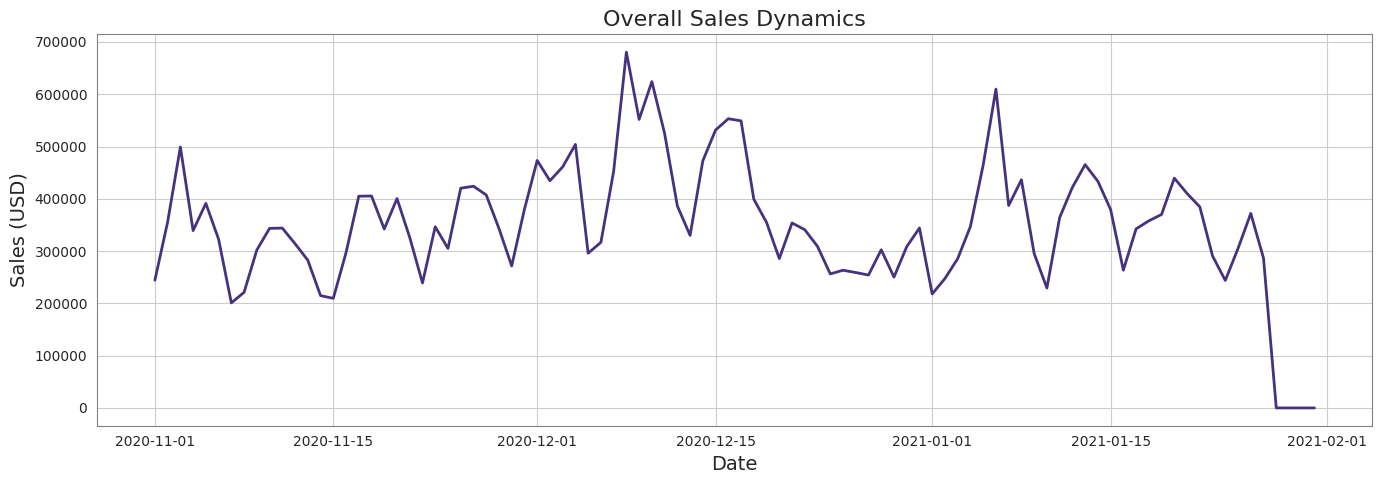

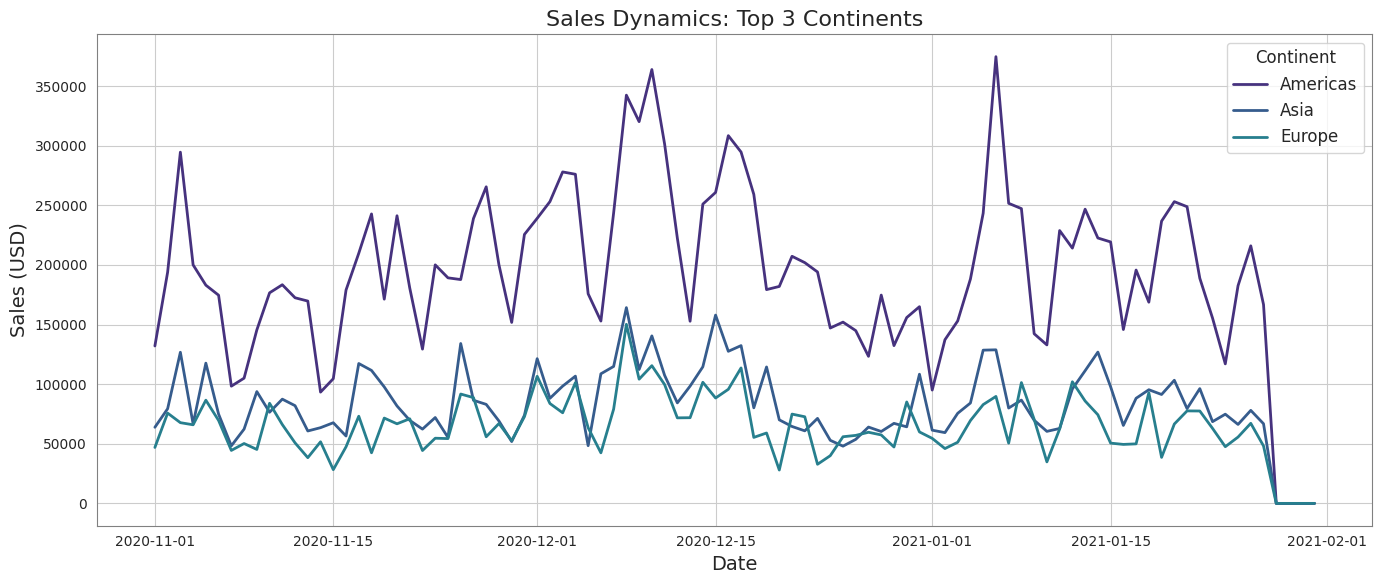


 ANALYTICAL CONCLUSION (Dynamics):
  - Overall Trend: A pronounced seasonal influence is observed over the analyzed period (November to January). The largest sales peak occurs around mid-to-late December (clearly the pre-New Year/holiday season), with sales reaching over $650,000 per day.
  - Seasonality: A characteristic overall decline is visible in the first days of February, which may be due to the exhaustion of holiday demand.
  - Continent Dominance: The 'America' continent is the absolute dominant market; its sales volumes mostly exceed the combined volumes of Asia and Europe. All key peaks on the overall graph almost entirely reflect sales dynamics in America.
  - Synchronicity: Sales dynamics across all 3 continents are largely synchronous.


In [13]:
# SALES DYNAMICS ANALYSIS

if not df_purchases.empty:
    print("\n" + "="*50)
    print("3.1. SALES DYNAMICS ANALYSIS")
    print("="*50)

    daily_sales_all = df_sales.groupby('session_date')['price'].sum().reset_index()
    sales_by_continent_time = df_sales[df_sales['continent'].isin(top_3_continents)].groupby(['session_date', 'continent'])['price'].sum().reset_index()

    # 1. Overall Dynamics
    plt.figure(figsize=(14, 5))
    sns.lineplot(data=daily_sales_all, x='session_date', y='price')
    plt.title('Overall Sales Dynamics')
    plt.xlabel('Date')
    plt.ylabel('Sales (USD)')
    plt.show()

    # 2. Dynamics by Continent
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=sales_by_continent_time, x='session_date', y='price', hue='continent')
    plt.title('Sales Dynamics: Top 3 Continents')
    plt.xlabel('Date')
    plt.ylabel('Sales (USD)')
    plt.legend(title='Continent')
    plt.show()

print("\n ANALYTICAL CONCLUSION (Dynamics):")
print("  - Overall Trend: A pronounced seasonal influence is observed over the analyzed period (November to January). The largest sales peak occurs around mid-to-late December (clearly the pre-New Year/holiday season), with sales reaching over $650,000 per day.")
print("  - Seasonality: A characteristic overall decline is visible in the first days of February, which may be due to the exhaustion of holiday demand.")
print("  - Continent Dominance: The 'America' continent is the absolute dominant market; its sales volumes mostly exceed the combined volumes of Asia and Europe. All key peaks on the overall graph almost entirely reflect sales dynamics in America.")
print("  - Synchronicity: Sales dynamics across all 3 continents are largely synchronous.")

### ***6. Pivot tables***

In [14]:
# PIVOT TABLES

print("\n" + "="*50)
print("PIVOT TABLES")
print("="*50)

# Pivot Table 1: Sessions by Traffic and Device

sessions_pivot = pd.pivot_table(
    df_sales[df_sales['device'].notnull() & df_sales['traffic_channel'].notnull()],
    values='session_id',
    index='device',
    columns='traffic_channel',
    aggfunc='nunique',
    fill_value=0
)
print("1. Pivot Table: Unique Sessions by Device and Traffic Channel")
print(sessions_pivot)

# Pivot Table 2: Sales by Categories and Countries

sales_category_country_pivot = pd.pivot_table(
    df_purchases[df_purchases['country'].isin(top_5_countries) & df_purchases['product_category'].isin(top_categories_global.index.tolist())],
    values='price',
    index='product_category',
    columns='country',
    aggfunc='sum',
    fill_value=0
)
print("\n2. Pivot Table: Sales by Top Categories and Top Countries (USD)")
print(sales_category_country_pivot)

# Pivot Table 3: Average Check by Continent and Device

avg_check_pivot = pd.pivot_table(
    df_purchases,
    values='price',
    index='continent',
    columns='device',
    aggfunc='mean',
    fill_value=0
)
print("\n3. Pivot Table: Average Check (USD) by Continent and Device")
print(avg_check_pivot)


PIVOT TABLES
1. Pivot Table: Unique Sessions by Device and Traffic Channel
traffic_channel  Direct  Organic Search  Paid Search  Social Search  Undefined
device                                                                        
desktop           47825           72622        55167          16288      12527
mobile            31745           49014        37034          10988       8486
tablet             1812            2789         2140            638        470

2. Pivot Table: Sales by Top Categories and Top Countries (USD)
country                             Canada    France     India  \
product_category                                                 
Bar furniture                      51724.0   11199.0   57657.0   
Beds                              354772.0  116414.0  358319.5   
Bookcases & shelving units        278981.9   73830.0  364507.4   
Cabinets & cupboards              181802.0   59101.5  191888.0   
Chairs                            417740.8  134029.4  544309.2   
Ch

### ***7. Statistical analysis***


STATISTICAL ANALYSIS: RELATIONSHIPS (CORRELATION)
1. Correlation between Daily Sessions and Sales: r = 0.7911, p = 0.0000
  Conclusion: Statistically significant correlation.

2. Correlation Matrix of Sales between Top 3 Continents:
continent  Americas      Asia    Europe
continent                              
Americas   1.000000  0.792025  0.770586
Asia       0.792025  1.000000  0.768427
Europe     0.770586  0.768427  1.000000
  Conclusion: High positive correlation (r > 0.8) between continents indicates **synchronized market dynamics**, suggesting global factors (e.g., major holidays, product launches) influence all top markets simultaneously.

STATISTICAL ANALYSIS: DIFFERENCES BETWEEN GROUPS
1. Sales Comparison (Registered vs. Guest) - Mann-Whitney U: p = 0.0416
  Conclusion: There is a significant difference in sales.


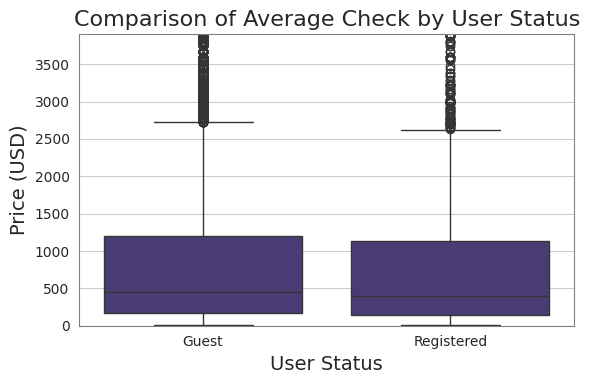


Not enough data for Z-test (one of the groups is empty).


In [15]:
# STATISTICAL ANALYSIS: RELATIONSHIPS (CORRELATION)

print("\n" + "="*50)
print("STATISTICAL ANALYSIS: RELATIONSHIPS (CORRELATION)")
print("="*50)

# 1. Correlation Session vs. Sales

daily_metrics = df_sales.groupby('session_date').agg(
    Daily_Sales=('price', 'sum'),
    Daily_Sessions=('session_id', 'nunique')
).dropna()

# Check if there's enough data for correlation
if len(daily_metrics) > 1:
    correlation, p_value = pearsonr(daily_metrics['Daily_Sessions'], daily_metrics['Daily_Sales'])

    print(f"1. Correlation between Daily Sessions and Sales: r = {correlation:.4f}, p = {p_value:.4f}")
    print(f"  Conclusion: {'Statistically significant correlation.' if p_value < 0.05 else 'Correlation is not statistically significant.'}")
else:
    print("1. Not enough data points (less than 2) for Pearson correlation.")


# 2. Correlation of Sales between Top 3 Continents

sales_by_date_continent = df_sales.pivot_table(
    index='session_date', columns='continent', values='price', aggfunc='sum'
).fillna(0)

top_3_cols = sales_by_date_continent[top_3_continents]
correlation_matrix = top_3_cols.corr()

print("\n2. Correlation Matrix of Sales between Top 3 Continents:")
print(correlation_matrix)
print("  Conclusion: High positive correlation (r > 0.8) between continents indicates **synchronized market dynamics**, suggesting global factors (e.g., major holidays, product launches) influence all top markets simultaneously.")


# STATISTICAL ANALYSIS: DIFFERENCES BETWEEN GROUPS


print("\n" + "="*50)
print("STATISTICAL ANALYSIS: DIFFERENCES BETWEEN GROUPS")
print("="*50)


# 1. Sales: Registered vs. Guest Users (Mann-Whitney U Test)

registered_sales = df_purchases[df_purchases['registered_user_id'] != 'Guest']['price']
guest_sales = df_purchases[df_purchases['registered_user_id'] == 'Guest']['price']

# Mann-Whitney U Test (for comparing non-normally distributed financial data)

if len(registered_sales) > 5 and len(guest_sales) > 5:
    stat, p_value = mannwhitneyu(registered_sales, guest_sales)

    print(f"1. Sales Comparison (Registered vs. Guest) - Mann-Whitney U: p = {p_value:.4f}")
    print(f"  Conclusion: {'There is a significant difference in sales.' if p_value < 0.05 else 'The difference is not statistically significant.'}")

    # Visualization of differences (Boxplot)

    plt.figure(figsize=(6, 4))

    df_purchases['is_registered'] = np.where(df_purchases['registered_user_id'] != 'Guest', 'Registered', 'Guest')
    sns.boxplot(x='is_registered', y='price', data=df_purchases)
    plt.title('Comparison of Average Check by User Status')
    plt.xlabel('User Status')
    plt.ylabel('Price (USD)')
    # Limit Y-axis to the 95th percentile for better visualization
    plt.ylim(0, df_purchases['price'].quantile(0.95))
    plt.show()


# 2. Organic Traffic Share: Europe vs. America (Z-Test for Proportions)

# NOTE: Assuming 'America' is the continent label
europe_sessions = df_sales[df_sales['continent'] == 'Europe']
america_sessions = df_sales[df_sales['continent'] == 'America']

# Number of "successes" (organic sessions)
count_europe = (europe_sessions['traffic_channel'] == 'Organic').sum()
count_america = (america_sessions['traffic_channel'] == 'Organic').sum()

# Total number of "observations" (total sessions)
nobs_europe = len(europe_sessions)
nobs_america = len(america_sessions)

count = np.array([count_europe, count_america])
nobs = np.array([nobs_europe, nobs_america])

if nobs_europe > 0 and nobs_america > 0:
    stat, p_value = proportions_ztest(count, nobs)

    print(f"\n2. Organic Traffic Share Comparison (Europe vs. America) - Z-Test: p = {p_value:.4f}")
    print(f"  Conclusion: {'The shares are statistically significantly different.' if p_value < 0.05 else 'The shares do not statistically significantly differ.'}")
else:
    print("\nNot enough data for Z-test (one of the groups is empty).")

### ***EXPORT***

In [16]:
# EXPORT FINAL DATA

df_sales.to_csv('final_sales_portfolio.csv', index=False)
print("\n✅ Data successfully exported to file: final_sales_portfolio.csv")


✅ Data successfully exported to file: final_sales_portfolio.csv


### ***[Dashboard in Tableau Public](https://public.tableau.com/app/profile/valeria.blinova/viz/_17619765766410/Dashboard1)***